In [37]:
# Disable GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from bokeh.plotting import output_notebook
output_notebook()

from src.utils import *

Loading BokehJS ...

In [3]:
%cd ..

D:\anomaly-detection


## Загрузка данных

In [38]:
data = pd.read_csv('data/processed/tep_data.csv', index_col='Index')
print(f'Len of dataset: {data.shape[0]}')

Len of dataset: 12801


In [7]:
from src.features.build_features import rolling_window

window_length = 64
prediction_len = 2
component = 3

# Create rolling windows with fixed length of some component.
X = rolling_window(data, window_length, 0)[:-prediction_len, :, component, None]
y = rolling_window(data, window_length, prediction_len)[:, :, component, None]

## Обучение модели

### Установка гиперпараметров

In [11]:
from src.models.lstm import lstm_model
import keras

build_params = dict(
    input_length=window_length,
    input_shape=X.shape[-1],
    lstm_layers_size=[2, 2],
    dropout_coeff=0.1,
    optimizer=keras.optimizers.Adam(lr=0.01),
    reg_strength=0.005,
)

fit_params = dict(
    batch_size=64,
    epochs=10,
    verbose=1,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(patience=3),
        keras.callbacks.EarlyStopping(min_delta=0.01, patience=5)
    ]
)

### Кросс-валидация

In [12]:
from src.utils import cross_validate

results = cross_validate(lambda: lstm_model(**build_params), 3, fit_params, X, y)

Fold 0...




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 3186 samples, validate on 3183 samples
Epoch 1/10
3186/3186 [==============================] - 6s 2ms/step - loss: 0.5834 - val_loss: 0.4676
Epoch 2/10
3186/3186 [==============================] - 4s 1ms/step - loss: 0.3928 - val_loss: 0.3842
Epoch 3/10
3186/3186 [==============================] - 4s 1ms/step - loss: 0.3622 - val_loss: 0.3694
Epoch 4/10
3186/3186 [==============================] - 4s 1ms/step - loss: 0.3558 - val_loss: 0.3675
Epoch 5/10
3186/3186 [==============================] - 4s 1ms/step - loss: 0.3518 - val_loss: 0.3601
Epoch 6/10
3186/3186 [==============================] - 4s 1ms/step - loss: 0.3482 - val_loss: 0.3575
Epoch 7/10
3186/3186 [==============================] - 4s 1ms/step - loss: 0.3463 - val_loss: 0.3520
Epoch 8/10
31

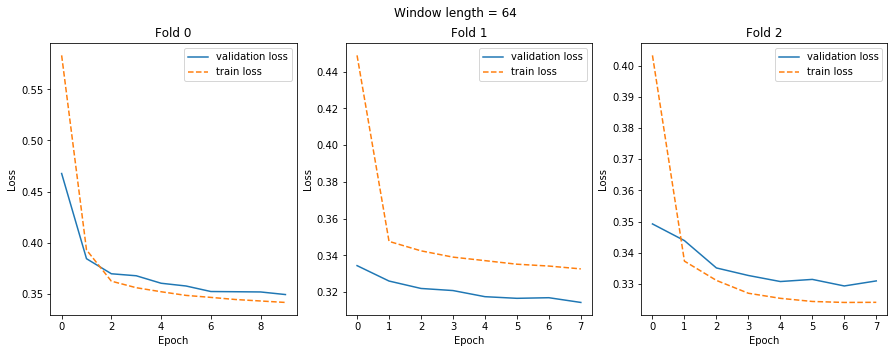

In [13]:
from src.visualization.visualize import visualize_cv_result

visualize_cv_result(results, f'Window length = {window_length}')

### Обучение на всех данных

In [15]:
model = lstm_model(**build_params)
model.fit(X, y, **fit_params)

Epoch 1/10
12735/12735 [==============================] - 16s 1ms/step - loss: 0.4269
Epoch 2/10
  128/12735 [..............................] - ETA: 14s - loss: 0.3672

/home/elch10/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:1109: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: loss,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/home/elch10/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


12735/12735 [==============================] - 15s 1ms/step - loss: 0.3535
Epoch 3/10
12735/12735 [==============================] - 15s 1ms/step - loss: 0.3432
Epoch 4/10
12735/12735 [==============================] - 15s 1ms/step - loss: 0.3375
Epoch 5/10
12735/12735 [==============================] - 15s 1ms/step - loss: 0.3337
Epoch 6/10
12735/12735 [==============================] - 15s 1ms/step - loss: 0.3315
Epoch 7/10
12735/12735 [==============================] - 15s 1ms/step - loss: 0.3302
Epoch 8/10
12735/12735 [==============================] - 15s 1ms/step - loss: 0.3289
Epoch 9/10
12735/12735 [==============================] - 15s 1ms/step - loss: 0.3280
Epoch 10/10
12735/12735 [==============================] - 15s 1ms/step - loss: 0.3274


In [16]:
model.save('models/onedimensional_lstm.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64, 2)             32        
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 2)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64, 2)             40        
_________________________________________________________________
time_distributed_1 (TimeDist (None, 64, 1)             3         
Total params: 75
Trainable params: 75
Non-trainable params: 0
_________________________________________________________________


## Нахождение оптимального порогового значения

In [14]:
from keras.models import load_model

model = load_model('models/onedimensional_lstm.h5')

In [15]:
from src.data.generate import generate_anomalies

anom_dataset = np.zeros(data.shape[0])
anoms = generate_anomalies(window_length)
for i in range(0, data.shape[0] - window_length, window_length):
    anom_dataset[i:i+window_length] = anoms[np.random.randint(len(anoms))]

In [16]:
X_all_anom = rolling_window(pd.DataFrame(anom_dataset), window_length)[:-prediction_len]

In [17]:
from src.utils import recall_all_tresh, compute_diff

anom_diffs = compute_diff(model, X_all_anom, y) 
anom_treshs, anom_recalls = recall_all_tresh(anom_diffs, np.ones_like(anom_diffs), window_length)

In [18]:
normal_diffs = compute_diff(model, X, y)
norm_recalls = []

for tresh in anom_treshs:
    recall = (normal_diffs < tresh).sum() / normal_diffs.shape[0]
    norm_recalls.append(recall)

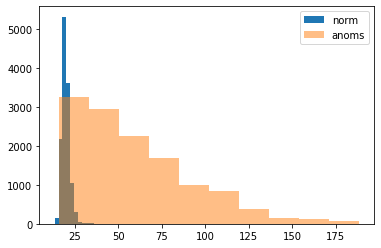

In [19]:
plt.hist(normal_diffs, label='norm')
plt.hist(anom_diffs, alpha=0.5, label='anoms')
plt.legend();

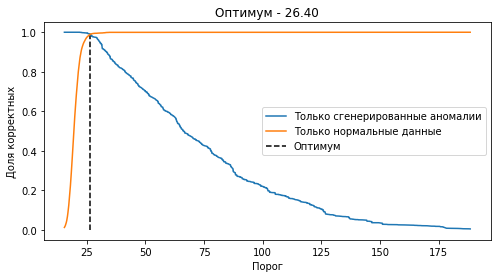

In [41]:
plt.figure(figsize=(8, 4))

plt.plot(anom_treshs, anom_recalls, label='Только сгенерированные аномалии')
plt.plot(anom_treshs, norm_recalls, label='Только нормальные данные')
optimum = anom_treshs[np.argmin(
    np.abs(np.array(anom_recalls) - np.array(norm_recalls)))]

plt.vlines(optimum, 0, 1, linestyles='dashed', label='Оптимум')

plt.title(f'Оптимум - {optimum:.2f}')
plt.xlabel('Порог')
plt.ylabel('Доля корректных')
plt.legend()

## Генерация и вставка аномалий в нормальные данные

In [28]:
data_with_anom = data[str(component)].copy()
anom_amount = 50

anom_idxs_start = np.random.choice(len(data_with_anom),
                                   anom_amount,
                                   replace=False)
anom_lens = np.zeros(anom_amount, dtype=int)
anom_idxs = np.zeros(len(data_with_anom), dtype=int)

for i, idx in enumerate(anom_idxs_start):
    l = np.random.randint(window_length, window_length * 2)

    if idx + l > data_with_anom.shape[0]:
        raise Exception('Try again, index out of range (FIXME THEN)')

    anom_lens[i] = l
    anoms = generate_anomalies(l)
    anom_idxs[idx:idx + l] = 1
    data_with_anom[idx:idx + l] = anoms[np.random.randint(len(anoms))]

In [29]:
X_with_anomalies = rolling_window(pd.DataFrame(data_with_anom), window_length)[:-prediction_len]

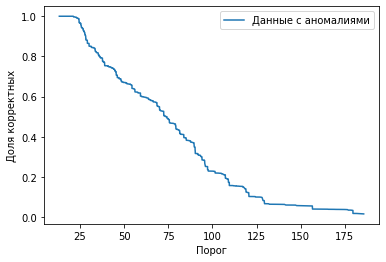

In [30]:
from src.utils import recall_all_tresh, compute_diff

diff = compute_diff(model, X_with_anomalies, y)
treshs, recalls = recall_all_tresh(diff, anom_idxs[:len(diff)], window_length)

plt.plot(treshs, recalls, label='Данные с аномалиями')
plt.xlabel('Порог')
plt.ylabel('Доля корректных')
plt.legend();

Выберем порог, который получили в прошлый раз

In [32]:
from sklearn.metrics import recall_score, precision_score

tresh = optimum
anoms_pred = np.where(diff >= optimum)[0]
recall = intersection_over_true(data.shape[0], anom_idxs_start, anom_lens,
                                anoms_pred, window_length, recall_score)
precision = intersection_over_true(data.shape[0], anom_idxs_start, anom_lens,
                                   anoms_pred, window_length, precision_score)
print(f'Полнота={recall:.3f}, Точность={precision:.3f}, Порог={tresh:.2f}')

Полнота=0.940, Точность=0.579, Порог=26.40


In [39]:
from bokeh.plotting import figure, show
from src.utils import *

p = figure(plot_width=700,
           plot_height=480,
           tools="xwheel_zoom,pan,box_zoom,reset")

# all_data
# anomalies generated
# model predicted


p.multi_line(
    [
        data_with_anom.index,
        *[list(range(idx, idx + l)) for idx, l in zip(anom_idxs_start, anom_lens)],
        *[list(range(idx, idx + window_length)) for idx in anoms_pred],
    ],
    [
        data_with_anom,
        *[
            data_with_anom.iloc[idx:idx + l]
            for idx, l in zip(anom_idxs_start, anom_lens)
        ],
        *[data_with_anom.iloc[idx:idx + window_length] for idx in anoms_pred],
    ],
    color=["green", *['red'] * len(anom_idxs_start), *['blue'] * len(anoms_pred)],
    alpha=[0.4, *[0.6] * len(anom_idxs_start), *[0.6] * len(anoms_pred)],
    line_width=4,
    legend=f'Recall={recall:.3f}, Precision={precision:.3f}',
)

GlyphRenderer(id='1257', ...)

In [40]:
# Blue - anomalies predicted by model
# Red - anomalies that was not catched by model
# Green - original data, that is neither anomaly nor predicted as anomaly

show(p)